# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [11]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
!nvidia-smi

Sat Mar  8 17:18:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [6]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [14]:
words = Counter()

translate_table = str.maketrans({k: None for k in string.punctuation})

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    proccessed_text = example.lower().translate(translate_table)

    for word in word_tokenize(proccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [30]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(input_batch: List[List[int]],
                            pad_id=word2ind['<pad>'],
                            max_len=256) -> torch.Tensor:
    # длины текстов в батче
    seq_lens = [len(x['text']) for x in input_batch]
    # минимум из максимальной длины текста в батче и max_len (256)
    max_seq_len = min(max(seq_lens), max_len)

    # ограничиваем сверху длину всех текстов в батче
    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    # переносим на GPU
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    # делаем новый батч
    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

Посмотрим, как выглядит наш датасет

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [17]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [19]:
print("label:", train_dataset.data['label'][0])
print("text:", train_dataset.data['text'][0])

label: 2
text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


Убедимся, что у нас 4 класса

In [29]:
print(set(train_dataset.data['label']))
print(set(eval_dataset.data['label']))

{0, 1, 2, 3}
{0, 1, 2, 3}


Как это выглядит в DataLoader уже после обработки текста

In [20]:
texts_example = next(iter(eval_dataloader))['input_ids']
labels_example = next(iter(eval_dataloader))['label']

print(texts_example.shape)

torch.Size([32, 62])


In [32]:
type(texts_example)

torch.Tensor

In [21]:
texts_example[0]

tensor([ 3238,  5147,  1041,  9239,  8204,  4124,  5147,  5147, 11038,  6684,
         7442, 11704,  6202,  8788,  5727,  2668,  4124,  2612,  9668, 11809,
         5147,  5147,  6684,   472,  4649,  4649,  4649,  4649,  4649,  4649,
         4649,  4649,  4649,  4649,  4649,  4649,  4649,  4649,  4649,  4649,
         4649,  4649,  4649,  4649,  4649,  4649,  4649,  4649,  4649,  4649,
         4649,  4649,  4649,  4649,  4649,  4649,  4649,  4649,  4649,  4649,
         4649,  4649], device='cuda:0')

In [23]:
" ".join([ind2word[i] for i in texts_example[0].tolist()])

'<bos> <unk> gets deeper into it <unk> <unk> the software maker adds a network management application it also updates its <unk> <unk> software <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [25]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# 1 Базовая модель

Модель из семинара

In [34]:
class CharLM(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 hidden_dim_rnn: int,
                 vocab_size: int,
                 num_classes: int = 4,
                 aggregation_type: str = 'max'):
        """
        Конструктор класса базовой модели с семинара

        Parameters
        ----------
        hidden_dim : int
            размерность эмбеддинга слов
        hidden_dim_rnn : int
            размерность скрытого слоя в RNN
        vocab_size : int
            размер словаря
        num_classes: int
            число классов
        aggregation_type: str
            тип агрегации векторов со скрытого слоя RNN

        """
        super().__init__()
        # переводим размерность словаря в размерность скрытого слоя
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # Переводим эмбеддинг в размерность RNN, в общем случае входная и выходная размерности не равны
        # На выходе - скрытые состояния для каждого из слов
        self.rnn = nn.RNN(hidden_dim, hidden_dim_rnn, batch_first=True)
        # Преобразование выходов RNN (пояснение см. ниже) в новый вектор, в общем случае размерности не одинаковые
        self.linear = nn.Linear(hidden_dim_rnn, hidden_dim)
        # Проекция на num_classes (4) класса для классификации
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        """
        Forward проход нейронной сети

        Parameters
        ----------
        input_batch: torch.Tensor
            тензор из индексов слов и текстов

        Returns
        -------
        prediction: torch.Tensor

        """
        # Эмбеддинг слов длиной seq_len в вектора размерности hidden_dim
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        # Здесь получаем уже другие вектора для каждого из слов в последовательности seq_len
        # Эти вектора - скрытые состояния RNN слоя для данного слова
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        # Чтобы свернуть размерность seq_len, берём максимум или среднее
        # В результате на выходе мы полчаем один вектор на текста, а не seq_len векторов
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        # Прогоняем полученное выше скрытое представление через полносвязную сеть
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

## Обучение модели

Инициализируем модель

In [35]:
model = CharLM(hidden_dim=256, hidden_dim_rnn=256, vocab_size=len(vocab), num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Заводим папку для сохранения весов моделей

In [36]:
import os

save_dir = "./saved_models/"
os.makedirs(save_dir, exist_ok=True)

Цикл обучения модели с небольшой поправкой: попробуем пербрать два вида аггрегации, чтобы оценить, какой лучше

In [40]:
num_epoch = 10
eval_steps = len(train_dataloader) // 2

losses_dict = {}
acc_dict = {}

# Перебираем оба вида агрегации
for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []
    best_acc = 0.0

    # Заводим модель, оптимизатор, критерий оптимизации
    model = CharLM(hidden_dim=256, hidden_dim_rnn=256, vocab_size=len(vocab),
                   aggregation_type=aggregation_type, num_classes=4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # цикл по эпохам
    for epoch in range(num_epoch):
        # Лоссы для данной эпохи
        epoch_losses = []
        # модель в режим обучения
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                # модель в режим валидаци
                model.eval()
                current_acc = evaluate(model, eval_dataloader)
                acc.append(current_acc)
                # Сохранение модели на каждой эпохе
                model_path = os.path.join(save_dir, f"baseline_model_{aggregation_type}_epoch_{epoch}.pt")
                torch.save(model.state_dict(), model_path)

                # Ещё сохранение лучшей модели каждого типа
                if current_acc > best_acc:
                    best_acc = current_acc
                    best_model_path = os.path.join(save_dir, f"best_model_{aggregation_type}.pt")
                    torch.save(model.state_dict(), best_model_path)
                    print(f"New best model saved for {aggregation_type} with accuracy {best_acc:.4f}")
                # на всякий случай модель в режим обучения
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_dict[aggregation_type] = losses
    acc_dict[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved for max with accuracy 0.2470
New best model saved for max with accuracy 0.8778


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved for max with accuracy 0.8780
New best model saved for max with accuracy 0.8950


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved for max with accuracy 0.8966


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved for max with accuracy 0.8968


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved for max with accuracy 0.9050


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved for max with accuracy 0.9072
New best model saved for max with accuracy 0.9126


Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved for mean with accuracy 0.2574
New best model saved for mean with accuracy 0.8778


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved for mean with accuracy 0.8838
New best model saved for mean with accuracy 0.8958


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved for mean with accuracy 0.8988


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved for mean with accuracy 0.9102


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

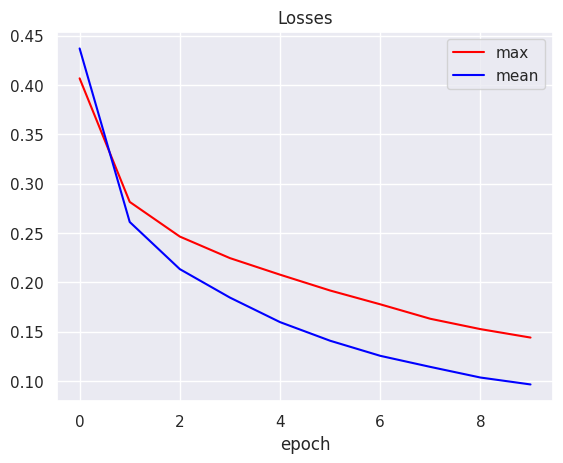

In [41]:
for (name, values), color in zip(losses_dict.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_dict[name])), losses_dict[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.26
Лучшая accuracy для подхода mean: 91.02


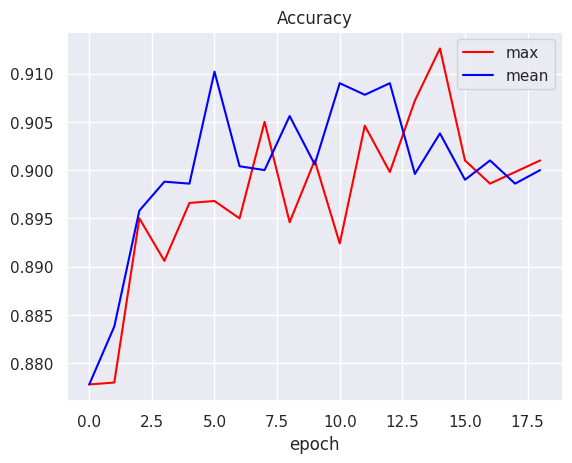

In [42]:
for (name, values), color in zip(acc_dict.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_dict[name][1:])), acc_dict[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_dict[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [43]:
acc_dict[name]

[0.2574000060558319,
 0.8777999877929688,
 0.8837999701499939,
 0.895799994468689,
 0.8987999558448792,
 0.8985999822616577,
 0.9101999998092651,
 0.9003999829292297,
 0.8999999761581421,
 0.9055999517440796,
 0.9005999565124512,
 0.9089999794960022,
 0.9077999591827393,
 0.9089999794960022,
 0.8995999693870544,
 0.9037999510765076,
 0.8989999890327454,
 0.9009999632835388,
 0.8985999822616577,
 0.8999999761581421]

## Вывод

- Обучать с данной архитекторой дольше 5 эпох нет смысла
- Мне больше нрваится `mean` агрегация векторов со скрытого слоя RNN, так там чуть более стабильная точность

# 2 Эксперименты по улучшению

## Продвинутая версия модели

Позволяет варьировать различные гиперпараметры

In [91]:
class TextClassifier(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 hidden_dim_rnn: int,
                 vocab_size: int,
                 num_classes: int = 4,
                 aggregation_type: str = 'max',
                 rnn_type: str = 'RNN',
                 num_rnn_layers: int = 1,
                 fc_dims: list = [128],
                 dropout_rate: float = 0.1):
        """
        Parameters
        ----------
        hidden_dim : int
            Dimension of word embeddings
        hidden_dim_rnn : int
            Dimension of hidden state in RNN
        vocab_size : int
            Vocabulary size
        num_classes: int
            Number of output classes
        aggregation_type: str
            Type of aggregation ('max' or 'mean')
        rnn_type: str
            Type of RNN layer ('RNN', 'GRU', or 'LSTM')
        num_rnn_layers: int
            Number of RNN layers
        fc_dims: list
            List containing the sizes of fully connected layers
        """
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        rnn_layer = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}.get(rnn_type)
        if rnn_layer is None:
            raise ValueError("Invalid rnn_type. Choose from 'RNN', 'GRU', 'LSTM'")

        self.rnn = rnn_layer(hidden_dim, hidden_dim_rnn, num_layers=num_rnn_layers, batch_first=True)

        self.aggregation_type = aggregation_type

        fc_layers = []
        in_dim = hidden_dim_rnn  # Input dimension to the first fully connected layer

        self.dropout_rate = dropout_rate

        for dim in fc_dims:
            fc_layers.append(nn.Linear(in_dim, dim))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(p=dropout_rate))
            in_dim = dim  # Update input dimension for next layer

        self.fc_layers = nn.Sequential(*fc_layers)
        self.projection = nn.Linear(in_dim, num_classes)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim_rnn]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]  # [batch_size, hidden_dim_rnn]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)  # [batch_size, hidden_dim_rnn]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.fc_layers(output)  # Pass through fully connected layers
        prediction = self.projection(output)  # [batch_size, num_classes]

        return prediction


## Фнукция для обучения моделей

Позволяет не переписывать цикл обучения модели каждый раз

In [92]:
def train_model(model, expirement_name,
                train_dataloader=train_dataloader,
                eval_dataloader=eval_dataloader,
                device='cuda', save_dir=save_dir, num_epoch=5):
    """
    Trains the given model and returns accuracy, loss, and hyperparameters.

    Parameters
    ----------
    model : nn.Module
        The neural network model to train.
    train_dataloader : DataLoader
        DataLoader for training data.
    eval_dataloader : DataLoader
        DataLoader for evaluation data.
    device : torch.device
        The device to train on.
    save_dir : str
        Directory to save models.
    num_epoch : int, optional
        Number of training epochs (default is 10).
    eval_steps : int, optional
        Number of steps between evaluations (default is half of train_dataloader length).

    Returns
    -------
    tuple
        (list of accuracies, list of losses per epoch, dictionary of model hyperparameters)
    """
    eval_steps = len(train_dataloader) // 2

    losses = []
    acc = []
    best_acc = 0.0

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()

        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].to(device))
            loss = criterion(logits, batch['label'].to(device))
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

            if i % eval_steps == 0:
                model.eval()
                current_acc = evaluate(model, eval_dataloader)
                acc.append(current_acc)

                model_path = os.path.join(save_dir, f"model_{expirement_name}_epoch_{epoch}.pt")
                torch.save(model.state_dict(), model_path)

                if current_acc > best_acc:
                    best_acc = current_acc
                    best_model_path = os.path.join(save_dir, "best_model.pt")
                    torch.save(model.state_dict(), best_model_path)
                    print(f"New best model saved with accuracy {best_acc:.4f}")

                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    hyperparameters = {
        'hidden_dim': model.embedding.embedding_dim,
        'hidden_dim_rnn': model.rnn.hidden_size,
        'num_rnn_layers': model.rnn.num_layers,
        'aggregation_type': model.aggregation_type,
        'fc_dims': [layer.out_features for layer in model.fc_layers if isinstance(layer, nn.Linear)],
        'num_classes': model.projection.out_features,
        'dropout_rate': model.dropout_rate,
    }

    return acc, losses, hyperparameters

## Эксперимент 1

Попробуем подобрать лучший тип рекурентного слоя: RNN, GRU, LSTM

In [57]:
rnn_layer_types = ['RNN', 'GRU', 'LSTM']

experiments_data = {}

for layer_type in rnn_layer_types:
    print(f"Testing model with recurent layers -> {layer_type}")
    current_experiment_name = f"exp_1_layer_types_{layer_type}"
    model = TextClassifier(hidden_dim=256,
                           hidden_dim_rnn=256,
                           vocab_size=len(vocab),
                           num_classes=4,
                           aggregation_type="mean",
                           rnn_type=layer_type, # только этот гиперпраметр варьируем
                           num_rnn_layers=1,
                           fc_dims=[128]).to(device)
    # Заводим словарь для данных моделей
    experiments_data[current_experiment_name] = {}
    # обучение
    accuracy, losses, heprparameters = train_model(model, expirement_name=current_experiment_name,
                                                   device=device)
    # запись в большой словарь по экспериментам
    experiments_data[current_experiment_name]['accuracy'] = accuracy
    experiments_data[current_experiment_name]['losses'] = losses
    experiments_data[current_experiment_name]['heprparameters'] = heprparameters

Testing model with recurent layers -> RNN


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2488
New best model saved with accuracy 0.8660


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.8904
New best model saved with accuracy 0.8988


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9016


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9030
New best model saved with accuracy 0.9050


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Testing model with recurent layers -> GRU


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2560
New best model saved with accuracy 0.8840


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9016
New best model saved with accuracy 0.9064


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9136
New best model saved with accuracy 0.9174


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Testing model with recurent layers -> LSTM


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2470
New best model saved with accuracy 0.8888


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9080
New best model saved with accuracy 0.9082


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9126


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9132


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

### Результаты эксперимента

In [58]:
experiments_data.keys()

dict_keys(['exp_1_layer_types_RNN', 'exp_1_layer_types_GRU', 'exp_1_layer_types_LSTM'])

In [74]:
import pandas as pd
import seaborn as sns

df_accuracy = pd.DataFrame()
df_losses = pd.DataFrame()

for title, value in experiments_data.items():
    df_accuracy_curr = pd.DataFrame(data={
        "model_title": title,
        "epoch": np.arange(len(value['accuracy'][1:])),
        "accuracy": value['accuracy'][1:],
    })
    df_losses_curr = pd.DataFrame(data={
        "model_title": title,
        "epoch": np.arange(len(value['losses'][1:])),
        "loss": value['losses'][1:],
    })
    df_accuracy = pd.concat([df_accuracy, df_accuracy_curr])
    df_losses = pd.concat([df_losses, df_losses_curr])

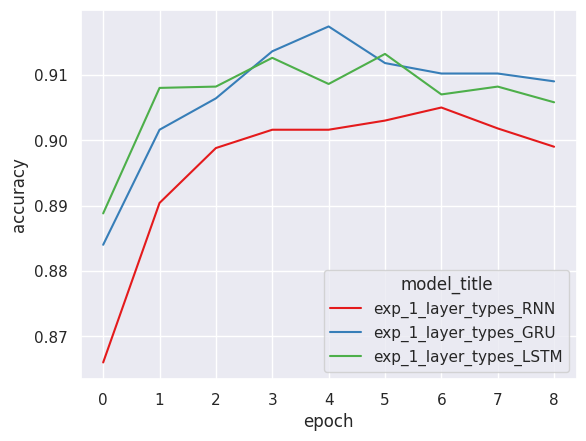

In [78]:
palette = sns.color_palette("Set1", 3)
sns.lineplot(df_accuracy, x="epoch",  y="accuracy", hue='model_title', palette=palette)
plt.show()

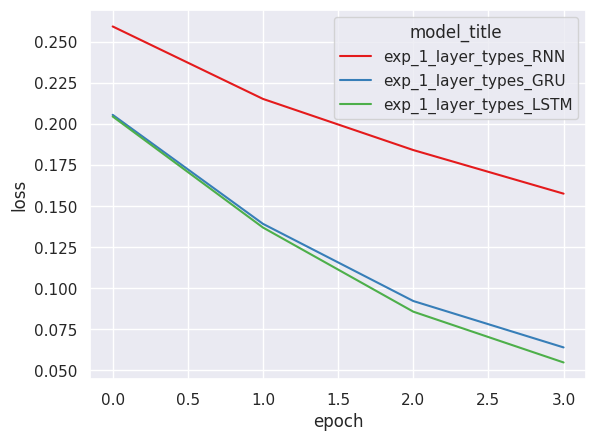

In [79]:
palette = sns.color_palette("Set1", 3)
sns.lineplot(df_losses, x="epoch",  y="loss", hue='model_title', palette=palette)
plt.show()

In [83]:
cut = df_accuracy['model_title'] == "exp_1_layer_types_GRU"
df_accuracy[cut]['accuracy'].max()

0.9174000024795532

### Вывод

Лучше всего работает GRU слой, он показывает точность на валидации **выше 0.91**

## Эксперимент 2

Возьмём лучшие рекурентный слой из эксперимента 1 - GRU и попробуем увеличить число слоёв. Есть ощущение, что больше трёх пробовать смысла нет, посмотрим

In [84]:
# С 1 слоем у нас уже есть запись
rnn_layer_numbers = [2, 3, 5]

for n_layers in rnn_layer_numbers:
    print(f"Testing model with n layers = {n_layers}")
    current_experiment_name = f"exp_2_GRU_nlayers_{n_layers}"
    model = TextClassifier(hidden_dim=256,
                           hidden_dim_rnn=256,
                           vocab_size=len(vocab),
                           num_classes=4,
                           aggregation_type="mean",
                           rnn_type="GRU",
                           num_rnn_layers=n_layers, # только этот гиперпраметр варьируем
                           fc_dims=[128]).to(device)
    # Заводим словарь для данных моделей
    experiments_data[current_experiment_name] = {}
    # обучение
    accuracy, losses, heprparameters = train_model(model, expirement_name=current_experiment_name,
                                                   device=device)
    # запись в большой словарь по экспериментам
    experiments_data[current_experiment_name]['accuracy'] = accuracy
    experiments_data[current_experiment_name]['losses'] = losses
    experiments_data[current_experiment_name]['heprparameters'] = heprparameters

Testing model with n layers = 2


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2394
New best model saved with accuracy 0.8944


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9050


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9178


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Testing model with n layers = 3


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2412
New best model saved with accuracy 0.8882


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9042
New best model saved with accuracy 0.9094


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9134


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Testing model with n layers = 5


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2568
New best model saved with accuracy 0.8678


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.8928
New best model saved with accuracy 0.8940


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9030


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9046
New best model saved with accuracy 0.9058


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [85]:
experiments_data.keys()

dict_keys(['exp_1_layer_types_RNN', 'exp_1_layer_types_GRU', 'exp_1_layer_types_LSTM', 'exp_2_GRU_nlayers_2', 'exp_2_GRU_nlayers_3', 'exp_2_GRU_nlayers_5'])

### Результаты эксперимента

In [86]:
df_accuracy = pd.DataFrame()
df_losses = pd.DataFrame()

for title, value in experiments_data.items():
    df_accuracy_curr = pd.DataFrame(data={
        "model_title": title,
        "epoch": np.arange(len(value['accuracy'][1:])),
        "accuracy": value['accuracy'][1:],
    })
    df_losses_curr = pd.DataFrame(data={
        "model_title": title,
        "epoch": np.arange(len(value['losses'][1:])),
        "loss": value['losses'][1:],
    })
    df_accuracy = pd.concat([df_accuracy, df_accuracy_curr])
    df_losses = pd.concat([df_losses, df_losses_curr])

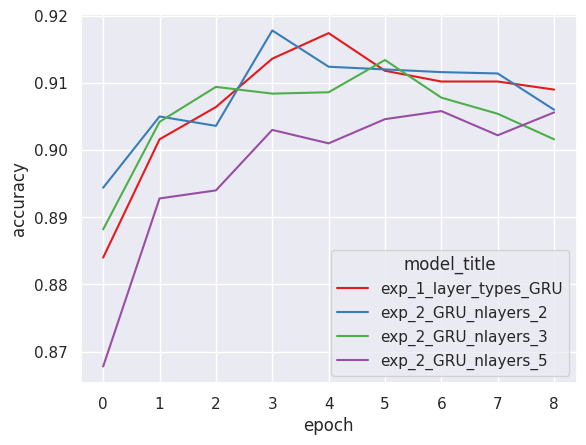

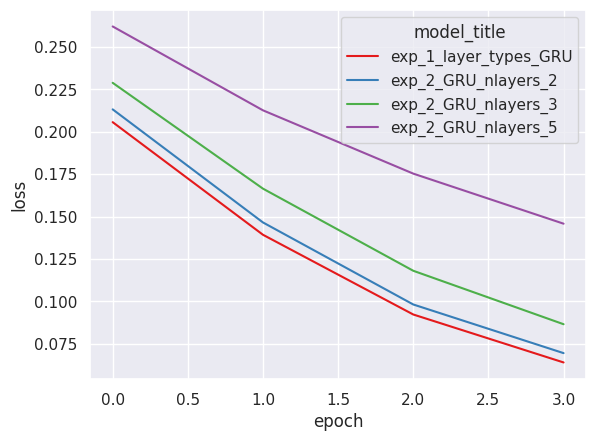

In [90]:
cut = df_accuracy["model_title"].apply(lambda x: "GRU" in x)

palette = sns.color_palette("Set1", 4)
sns.lineplot(df_accuracy[cut], x="epoch",  y="accuracy", hue='model_title', palette=palette)
plt.show()

cut = df_losses["model_title"].apply(lambda x: "GRU" in x)

palette = sns.color_palette("Set1", 4)
sns.lineplot(df_losses[cut], x="epoch",  y="loss", hue='model_title', palette=palette)
plt.show()

### Вывод

Лучше всего работает всё ещё модель с 1 слоем GRU. По графику loss кажется, что модель с 5 слоями учится медленнее и может обогнать модель с 1 слоем, но вряд ли разница в точности будет значительной

## Эксперимент 3

In [101]:
dropout_rates = [0.1, 0.2, 0.3]
fc_dims = [
    [128],
    [128, 64],
    [128, 64, 32],
]

for p in dropout_rates:
    for fc_dim in fc_dims:
        print(f"Testing model with dropout rate = {p}, fc dims = {fc_dim}")
        current_experiment_name = f"exp_3_GRU_nlayers_1_dropout_{p}_fc_dims_{'-'.join([str(x) for x in fc_dim])}"
        print(current_experiment_name)
        model = TextClassifier(hidden_dim=256,
                            hidden_dim_rnn=256,
                            vocab_size=len(vocab),
                            num_classes=4,
                            aggregation_type="mean",
                            rnn_type="GRU",
                            num_rnn_layers=1,
                            fc_dims=fc_dim,
                            dropout_rate=p).to(device)
        # Заводим словарь для данных моделей
        experiments_data[current_experiment_name] = {}
        # обучение
        accuracy, losses, heprparameters = train_model(model, expirement_name=current_experiment_name,
                                                    device=device)
        # запись в большой словарь по экспериментам
        experiments_data[current_experiment_name]['accuracy'] = accuracy
        experiments_data[current_experiment_name]['losses'] = losses
        experiments_data[current_experiment_name]['heprparameters'] = heprparameters

Testing model with dropout rate = 0.1, fc dims = [128]
exp_3_GRU_nlayers_1_dropout_0.1_fc_dims_128


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2512
New best model saved with accuracy 0.8948


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9082


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9176


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Testing model with dropout rate = 0.1, fc dims = [128, 64]
exp_3_GRU_nlayers_1_dropout_0.1_fc_dims_128-64


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2470
New best model saved with accuracy 0.8892


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9024
New best model saved with accuracy 0.9082


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9084


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9098
Testing model with dropout rate = 0.1, fc dims = [128, 64, 32]
exp_3_GRU_nlayers_1_dropout_0.1_fc_dims_128-64-32


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2502
New best model saved with accuracy 0.8906


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9094
New best model saved with accuracy 0.9144


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9148


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9150


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Testing model with dropout rate = 0.2, fc dims = [128]
exp_3_GRU_nlayers_1_dropout_0.2_fc_dims_128


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2766
New best model saved with accuracy 0.8916


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9056
New best model saved with accuracy 0.9118


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9134


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9142
Testing model with dropout rate = 0.2, fc dims = [128, 64]
exp_3_GRU_nlayers_1_dropout_0.2_fc_dims_128-64


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2414
New best model saved with accuracy 0.8930


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9066


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9118


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9140


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9148
Testing model with dropout rate = 0.2, fc dims = [128, 64, 32]
exp_3_GRU_nlayers_1_dropout_0.2_fc_dims_128-64-32


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2568
New best model saved with accuracy 0.8890


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9048


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9150


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Testing model with dropout rate = 0.3, fc dims = [128]
exp_3_GRU_nlayers_1_dropout_0.3_fc_dims_128


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2584
New best model saved with accuracy 0.8854


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9040
New best model saved with accuracy 0.9096


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9106


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Testing model with dropout rate = 0.3, fc dims = [128, 64]
exp_3_GRU_nlayers_1_dropout_0.3_fc_dims_128-64


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2668
New best model saved with accuracy 0.8808


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.8960
New best model saved with accuracy 0.9094


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9098


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9132


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Testing model with dropout rate = 0.3, fc dims = [128, 64, 32]
exp_3_GRU_nlayers_1_dropout_0.3_fc_dims_128-64-32


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.2568
New best model saved with accuracy 0.8884


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9016
New best model saved with accuracy 0.9116


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

New best model saved with accuracy 0.9138


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

### Результаты эксперимента

In [102]:
df_accuracy = pd.DataFrame()
df_losses = pd.DataFrame()

for title, value in experiments_data.items():
    df_accuracy_curr = pd.DataFrame(data={
        "model_title": title,
        "epoch": np.arange(len(value['accuracy'][1:])),
        "accuracy": value['accuracy'][1:],
    })
    df_losses_curr = pd.DataFrame(data={
        "model_title": title,
        "epoch": np.arange(len(value['losses'][1:])),
        "loss": value['losses'][1:],
    })
    df_accuracy = pd.concat([df_accuracy, df_accuracy_curr])
    df_losses = pd.concat([df_losses, df_losses_curr])

### Сохранение логов экспериментов

In [103]:
df_accuracy.to_csv("models_accuracy.csv")
df_losses.to_csv("models_losses.csv")

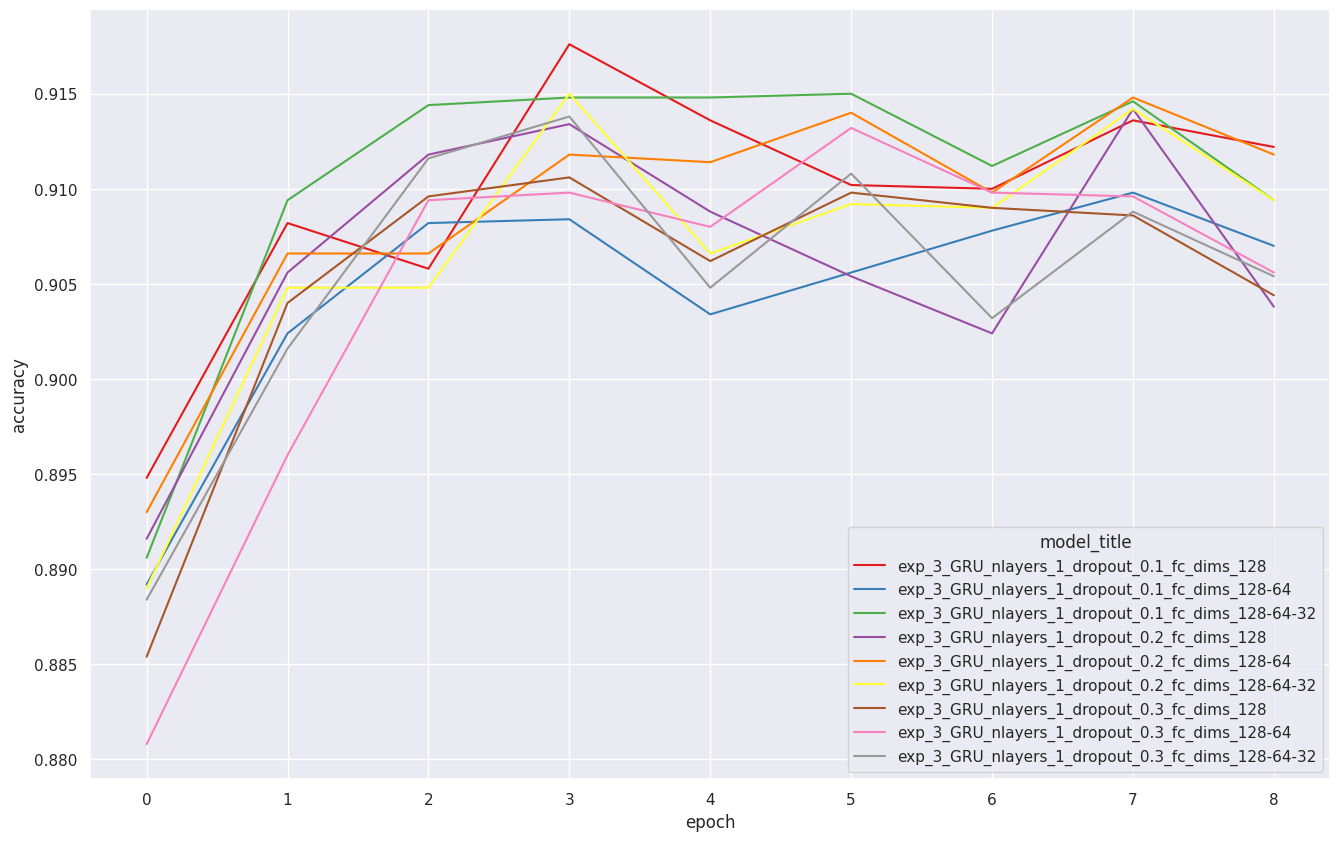

<ipython-input-112-aacb19314c24>:12: UserWarning: 
The palette list has fewer values (9) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df_losses[cut], x="epoch",  y="loss", hue='model_title', palette=palette)


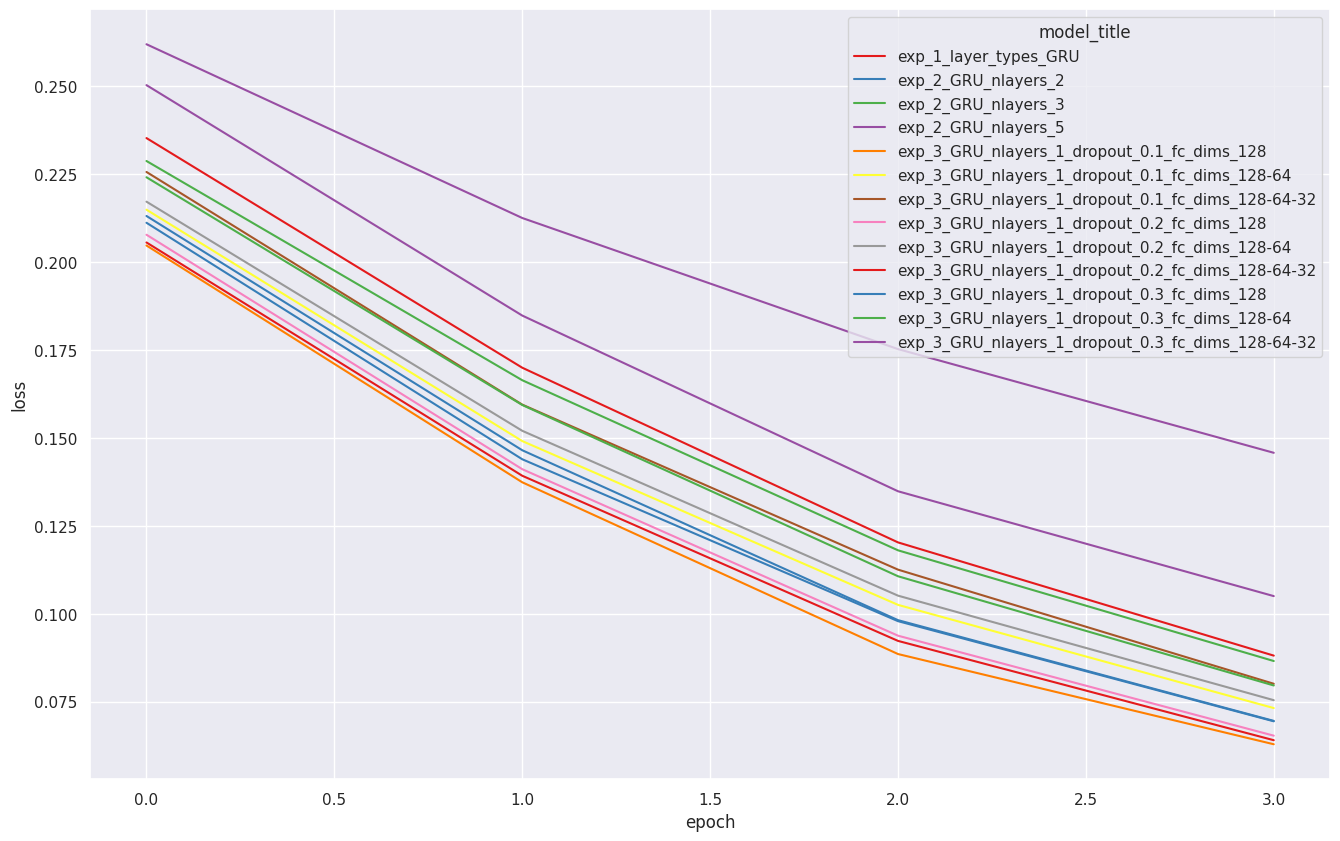

In [112]:
cut = df_accuracy["model_title"].apply(lambda x: "dropout" in x)

plt.figure(figsize=(16, 10))
palette = sns.color_palette("Set1", 9)
sns.lineplot(df_accuracy[cut], x="epoch",  y="accuracy", hue='model_title', palette=palette)
plt.show()

cut = df_losses["model_title"].apply(lambda x: "GRU" in x)

plt.figure(figsize=(16, 10))
palette = sns.color_palette("Set1", 9)
sns.lineplot(df_losses[cut], x="epoch",  y="loss", hue='model_title', palette=palette)
plt.show()

In [111]:
cut = df_accuracy["model_title"].apply(lambda x: "dropout" in x)
df_accuracy[cut].sort_values(by='accuracy', ascending=False)[:10]

,model_title,epoch,accuracy
3,exp_3_GRU_nlayers_1_dropout_0.1_fc_dims_128,3,0.9176
3,exp_3_GRU_nlayers_1_dropout_0.2_fc_dims_128-64-32,3,0.9150
5,exp_3_GRU_nlayers_1_dropout_0.1_fc_dims_128-64-32,5,0.9150
3,exp_3_GRU_nlayers_1_dropout_0.1_fc_dims_128-64-32,3,0.9148
7,exp_3_GRU_nlayers_1_dropout_0.2_fc_dims_128-64,7,0.9148
4,exp_3_GRU_nlayers_1_dropout_0.1_fc_dims_128-64-32,4,0.9148
7,exp_3_GRU_nlayers_1_dropout_0.1_fc_dims_128-64-32,7,0.9146
2,exp_3_GRU_nlayers_1_dropout_0.1_fc_dims_128-64-32,2,0.9144
7,exp_3_GRU_nlayers_1_dropout_0.2_fc_dims_128,7,0.9142
7,exp_3_GRU_nlayers_1_dropout_0.2_fc_dims_128-64-32,7,0.9142


### Вывод

Лучше всего себя показывают модели с 3 полносвязными слоями 128-64-32 и dropout rate = 0.1. Модель с 3 полносвязными слоями быстрее обучается и показывает более стабильное качество на валидационной выборке

# Отчёт

Бли проведены следующие эксперименты

0. Подборе метода агрегации эмбеддингов из RNN - лучший выявлен не был, но 'mean' давал более стабильное качество на валидации
1. Подбор типа рекурентного слоя нейронной сети - GRU даёт более высокую точность, чем RNN и LSTM
2. Увеличение числа рекурентных слоёв модели - результатов не принесло, 1 слой даёт лучшие метрики
3. Эксперимент с dropoout_rate (0.1, 0.2, 0.3) и структурой полносвзяных слоёв. Серьёзного улучшения не принесло, но модель с dropout_rate = 0.1 и полносвязными слоями 128-64-32 быстрее сходится и не наблюдается меньшее колебание метрики accuracy

Сходимость стабильная, больших колебаний метрики не наблюдается

Лучшие метрики `accuracy ~ 0.915` показала следующая модель:
* 1 слой GRU
* полносвязные слои 128-64-32
* dropout_rate = 0.1

В целом можно было бы ещё экспериментировать, но кажется, что более существенно выского качества можно добиться только с другим типом моделей.